# Question Answering

Irrespective of profession, everyone has to wade through ocean of documents at some point to find the information for their questions.  To make matters worse, we're constantly reminded by search engines there are better ways to search! For instance the earch query "When did Marie Curie win her first Nobel Prize?" And google get the correct answer of "1903".

So how was this search done? Google first retrieved 319,000 documents that were relevant to query, then performed a post processing step to extract the answer snippet with the coressponding passage and web page. But for a more trickier question like "Which guitar tuning is best?" We'll get web pages instead of an answer snippet.

The general approach behind this technology is called *question answering*(QA), but the most common is *extractive QA* which involves questions where answers can be identified as a span in a text document, where the document might be a web page, article, legal document etc.

This two stage process of retrieving relevant documents and then extracting answers from this is the basis of many modern QA systems like semantic search, intellegint assistants and automated information extractors. 

> **Note:** We're covering only extractive QA. There are others,
 * community QA Ex: In stack overflow, all the relevant question answer pairs will be retrived for the new Question from user and then using semantic similarity search to find the closest maching answer to this question.
 * long-form QA, which aims to generate complex paragraph-length answers to open ended questions like "Why sky is blue?"
 * QA can be done over tables as well, and transformer models like TAPAS can even peroform aggregations to produce the final answer!

## Use Case

In this notebook, we'll use QA system to solve a common problem facing ecommerce websites: helping consumers evaluate a product by answering specific queries. We'll see that the customer reviews can be used as a rich and challenging source of information for QA. Along the way we'll learn transformers capbality of *reading comprehehsion* and how the model can extract meaning from text.

## Building a Review-Based QA System

Let's say we want to buy a smartphone, and we've question on nightmode camera capbalities. This information is not readily available in product description. We can find the answer for this in reviews by other customers. But we might've to comb throuch thousands of reviews to find the relevant answer. It'll be great if we can have a search like google right? Let's do this using transformers!

### The Dataset

To build our QA system, we'll use [SubQA](https://arxiv.org/abs/2004.14283) dataset, which consists of 10,000+ reviews where each review is associated with a question and answer from one or more sentences from the review. The reviews are about products and services in six domains: TripAdvisor, Restaurants, Movies, Books, Electronics and Grocery.

*Data example*

![alt](../notes/images/7-question-answering/subqa-data-sample.png)

The intersting aspect of this dataset is question(from users), answers(extraced from reviews) are *subjective*. The question on camera quality from user, the quality is subjective to each user and answer might not be from the same point of view question is raised... This is why it's easier to answer fatcual questions like "What's the capital of a country"
Second, important parts of the question do not appear in review at all, so we can't use shortcuts like keyword search or paraphrasing the input question.

Because of these points, SubQA is a greate dataset to benchamrk review-based QA models, sicne user-generated content in the example resembles what we might encounter in the wild.

> **Note:** QA systems are categorized accordig to the domains it has access to while answering the questions. 
  * *Narrow QA* answers question about a single product less documents to search
  * *Open-domain QA* deals with questions about almost anything(eg. amazon's whole product catalog.) more documents to search

### The Dataset

To build our QA system, we'll use [SubQA](https://arxiv.org/abs/2004.14283) dataset, which consists of 10,000+ reviews where each review is associated with a question and answer from one or more sentences from the review. The reviews are about products and services in six domains: TripAdvisor, Restaurants, Movies, Books, Electronics and Grocery.

*Data example*

![alt](../notes/images/7-question-answering/subqa-data-sample.png)

The intersting aspect of this dataset is question(from users), answers(extraced from reviews) are *subjective*. The question on camera quality from user, the quality is subjective to each user and answer might not be from the same point of view question is raised... This is why it's easier to answer fatcual questions like "What's the capital of a country"
Second, important parts of the question do not appear in review at all, so we can't use shortcuts like keyword search or paraphrasing the input question.

Because of these points, SubQA is a greate dataset to benchamrk review-based QA models, sicne user-generated content in the example resembles what we might encounter in the wild.

> **Note:** QA systems are categorized accordig to the domains it has access to while answering the questions. 
  * *Narrow QA* answers question about a single product less documents to search
  * *Open-domain QA* deals with questions about almost anything(eg. amazon's whole product catalog.) more documents to search

### The Dataset

To build our QA system, we'll use [SubQA](https://arxiv.org/abs/2004.14283) dataset, which consists of 10,000+ reviews where each review is associated with a question and answer from one or more sentences from the review. The reviews are about products and services in six domains: TripAdvisor, Restaurants, Movies, Books, Electronics and Grocery.

*Data example*

![alt](../notes/images/7-question-answering/subqa-data-sample.png)

The intersting aspect of this dataset is question(from users), answers(extraced from reviews) are *subjective*. The question on camera quality from user, the quality is subjective to each user and answer might not be from the same point of view question is raised... This is why it's easier to answer fatcual questions like "What's the capital of a country"
Second, important parts of the question do not appear in review at all, so we can't use shortcuts like keyword search or paraphrasing the input question.

Because of these points, SubQA is a greate dataset to benchamrk review-based QA models, sicne user-generated content in the example resembles what we might encounter in the wild.

> **Note:** QA systems are categorized accordig to the domains it has access to while answering the questions. 
  * *Narrow QA* answers question about a single product less documents to search
  * *Open-domain QA* deals with questions about almost anything(eg. amazon's whole product catalog.) more documents to search

To get started , let's download the dataset from hub. we can use the `get_dataset_config_names()` function to find out which subsets are available:

In [2]:
from datasets import get_dataset_config_names

domains = get_dataset_config_names("subjqa")
domains

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In this notebook, we'll be focusing on developing a QA system for Electronic domain. To do that let's download the `electronics` subset.

In [3]:
from datasets import load_dataset
subjqa = load_dataset(
    path="subjqa",
    name="electronics"
)

Found cached dataset subjqa (/Users/jayaprakashsivagami/.cache/huggingface/datasets/subjqa/electronics/1.1.0/2c12e496c4c675ab4a57ffb5d3f538f2e7b89793956e50da37126393ce23b6c6)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
subjqa

DatasetDict({
    train: Dataset({
        features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers'],
        num_rows: 1295
    })
    test: Dataset({
        features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers'],
        num_rows: 358
    })
    validation: Dataset({
        features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers'],
        num_rows: 255
    })
})

In [5]:
# Features in the dataset
for i in subjqa["train"].features:
    print(i)

domain
nn_mod
nn_asp
query_mod
query_asp
q_reviews_id
question_subj_level
ques_subj_score
is_ques_subjective
review_id
id
title
context
question
answers


Like other question answering datasets on the Hub, SubjQA stores the answers to each questions as a nested dictionary. Let's inspect the answers column.

In [6]:
print(subjqa["train"]["answers"][1])

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1], 'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective': [True, True]}


In [7]:
# Answers has other nested keys inside
for k, v in subjqa["train"]["answers"][1].items():
    print(k)
    print(v)
    print("")

text
['Bass is weak as expected', 'Bass is weak as expected, even with EQ adjusted up']

answer_start
[1302, 1302]

answer_subj_level
[1, 1]

ans_subj_score
[0.5083333253860474, 0.5083333253860474]

is_ans_subjective
[True, True]



The answers are stored in `text` field, while the starting character indices are provided in `answer_start`. To explore the dataset more easily, let's flatten the nested dict and convert this to a `DataFrame`.

We'll use dataset's [flatten()](https://huggingface.co/docs/datasets/package_reference/main_classes#datasets.Dataset.flatten) to do this.

In [8]:
import pandas as pd
dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}
for split, df in dfs.items():
    print(f"Number of questions in {split}: {df['id'].nunique()}")

Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


In [9]:
dfs["train"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1295 entries, 0 to 1294
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   domain                     1295 non-null   object 
 1   nn_mod                     1295 non-null   object 
 2   nn_asp                     1295 non-null   object 
 3   query_mod                  1295 non-null   object 
 4   query_asp                  1295 non-null   object 
 5   q_reviews_id               1295 non-null   object 
 6   question_subj_level        1295 non-null   int64  
 7   ques_subj_score            1295 non-null   float32
 8   is_ques_subjective         1295 non-null   bool   
 9   review_id                  1295 non-null   object 
 10  id                         1295 non-null   object 
 11  title                      1295 non-null   object 
 12  context                    1295 non-null   object 
 13  question                   1295 non-null   objec

In [10]:
dfs["train"].head(2).T

,0,1
domain,electronics,electronics
nn_mod,great,harsh
nn_asp,bass response,high
query_mod,excellent,not strong
query_asp,bass,bass
q_reviews_id,0514ee34b672623dff659334a25b599b,7c46670208f7bf5497480fbdbb44561a
question_subj_level,5,1
ques_subj_score,0.5,0.5
is_ques_subjective,False,False
review_id,882b1e2745a4779c8f17b3d4406b91c7,ce76793f036494eabe07b33a9a67288a


There are quite a few columns, we'll use the below columns for this use case:

1. `title` -> Amazon Standard Identification Number (ASIN) associated with each product
2. `question` -> Question itself
3. `answers.answer_text` -> The span of text in the review labelled by annotator
4. `answers.answer_start` -> The start charachter index of the answer span
5. `context` -> The customer review

Let''s look at these columns alone.

In [11]:
qa_cols = ["title", "question", "answers.text", "answers.answer_start", "context"]
sample_df = dfs["train"][qa_cols].sample(2, random_state=7)
sample_df 

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...


Observations:

* The queries are not gramatically correct which is quite common in the FAQ sections of ecommerce websites.
* An empty `amswers.text` entry denotes "unanswerable" questions whose answer cannot be found in the review.
* We can use the start index and length of the answer span to slice out the span to get the answer from the text.

In [12]:
start_idx = sample_df["answers.answer_start"].iloc[0][0]
start_idx

215

In [13]:
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])
end_idx

239

In [14]:
sample_df["context"].iloc[0][start_idx:end_idx]

'this keyboard is compact'

In [15]:
sample_df["answers.text"].iloc[0]

array(['this keyboard is compact'], dtype=object)

By predicting the start index and length of the answer, we can create a qa model.

Next, let's get a feel for what types of questions are available in the training set by counting the questions that starts with a few common starting words for questions:

In [16]:
counts = {}
# Here we're assuming all users will start the question with capital letter...
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]

for q in question_types:
    # Get the questions start with q using value_counts()
    # value_counts() returns count for True(1st index) and False(0th index)
    # Get true from ther value_counts() and save it to dict
    false_true = dfs["train"]["question"].str.startswith(q).value_counts()
    if len(false_true) == 2:
        counts[q] = false_true[1]
    else:
        counts[q] = 0
counts

{'What': 236,
 'How': 515,
 'Is': 100,
 'Does': 45,
 'Do': 83,
 'Was': 12,
 'Where': 28,
 'Why': 21}

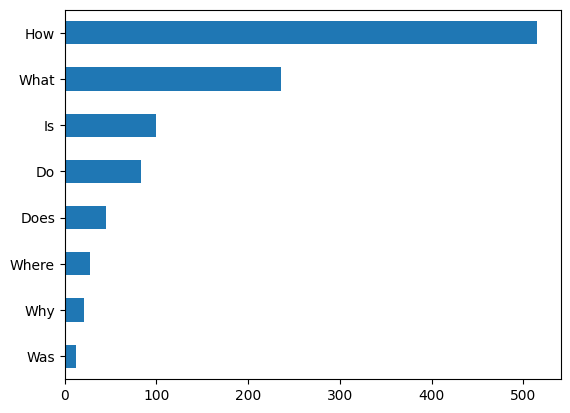

In [17]:
# Let's plot this
import matplotlib.pyplot as plt
pd.Series(counts).sort_values().plot.barh()
plt.show()

Most common questions begins with "How", "What", and "Is", let's have a look at some examples:

In [18]:
for question_type in question_types:
    print(question_type)
    for question in (
        dfs["train"][dfs["train"].question.str.startswith(question_type)].sample(n=3, random_state=42)["question"]
    ):
        print(question)
    print("")

What
What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?

How
How is the camera?
How do you like the control?
How fast is the charger?

Is
Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?

Does
Does the camera include control?
Does the product have good quality?
Does this provide enough storage?

Do
Do you have a price for a shoes?
Does this headphone excellent?
Do they come with the manufacturer's seal?

Was
Was the drive absolutely perfect?
Was prompt the delivery?
Was the mountain high?

Where
Where is the cheapest price?
Where can I send to setup my device?
Where do I have a drawer full of headphones?

Why
Why do I have an incredible sound?
Why is customer service excellent?
Why this feature affect the move?



### Question Answering Dataset history

 The (question, review, [answer setences]) format of SubjQA(used in [7-question-answering.ipynb notebook usecase for qa](../notebooks/7-question-answering.ipynb)) is commonly used in extractive QA datasets and was pioneered in Stanford Question Answering Dataset(SQuAD). 

 * SQuAD is a famous dataset to test the abilit of machines(models) to read a passage of text and answer questions about it
 * This dataset was created from several hundred articles from wikipedia, where each of the article was partioned into paragraphs. Then crowdworkers were asked to generate questions and answers for each paragraph.
 * In the first crowdworkers version of SQuAD, answers for questions were guaranteed to be in paragraphs.
 * Soon sequence to sequence models outperformed humans and predicted spans of answers for question in the context(paragraphs, reviews etc.)
 * SQuAD 2.0 was created by augmenting SQuAD 1.1 with a set of adversial questions that were relevant to the passage but can't be answered from the passage contents alone. This became a better benchmark for evaluation qa capabalities of machines.
 * SOTA models as of 2022 with most models since 2019 surpasses human performance.
    *qa sota models timeline*

    ![alt](../notes/images/7-question-answering/qa-sota-models.png)
* However this superhuman performance does not appear to reflect genuine reading comprehension, since answers to these "unanswerable" questions can be found by looking at antonymns in passages. 
* To address these problems Google released the Natural Questions (NQ) dataset which involves fact-seeking questions obtainef from Google Search users.
* The answers in NQ are much longer than in SQuAD and present a more challenging benchmark.

```
NQ >> SQuAD2.0 >> SQuAD
```

Now let's dive into how transformers can extract answers from text.

### Extracting Answers from Text

The first thing we'll need for our QA systems is to find a way to identify potential answers as span of text in a customer review. To do this, we'll need to understand how to:

1. Frame the supervised learning problem
2. Tokenize and encode text for QA tasks
3. Deal with long passages that exceed a model's maximum context size

#### Frame the problem - span classification

The most common way to extract answers is ny framing the problem as *Span classification task* where start and end tokens acts as lables to be predicted by the model.

*qa span classification*

![alt](../notes/images/7-question-answering/qa-span-classification.png)

In general we'll start with a pretrained model and evaluate it on the dataset to use it as a baseline and then fine-tune the model for the use case. But for extractive QA , we can actually start with fine-tuned model because the structure of labels remain the same. Since our training set is realtivley small with only 1,295 samples, A good strategy is to use a model fine-tuned on large-scale QA dataset like SQuAD.

*SQuAD models on hub as of 2nd Sep 2023*

![alt](../notes/images/7-question-answering/squad-models-on-hub.png)

Woah... 4000+ models are available, which model to use depends on mono or multi-lingual and production environment constraints.

*Baseline transformer models fine-tuned on SQuAD 2.0*
| Transformer | Description | Num of Params | F1-Score |
|----------|----------|----------|----------|
| MiniLM   | Distilled version of BERT-base that preserves 99% performance while being twice as fast   | 66M | 79.5 |
| RoBERTa-base | RoBERTa models have better performance than their BERT counterparts and can be fine-tuned on most QA datastes using a single GPU | 125M| 83.0 |
| ALBERT-XXL | SOTA on datasetm but computationally intensive and difficult to deploy | 253M | 88.1 |
| XLM-RoBERTa-large | Multilingual model for 100 languages with strong zero-shot performance | 570M | 83.8 |

In this notebook, we'll use MiniLM model since it is fast to train and will allows to iterate quickly to explore techniques. First we need the tokenizer to encode our texts. Let's take a look at how this works for QA tasks.

### Tokenizing text for QA

In [19]:
from transformers import AutoTokenizer

model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(
    pretrained_model_name_or_path=model_ckpt
)
tokenizer

PreTrainedTokenizerFast(name_or_path='deepset/minilm-uncased-squad2', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

> **Note:** In QA model inputs are passed as question, context pairs.

In [20]:
question = "How much music can this hold?"
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on \
file size."""
inputs = tokenizer(question, context, return_tensors="pt")
inputs

{'input_ids': tensor([[  101,  2129,  2172,  2189,  2064,  2023,  2907,  1029,   102,  2019,
         23378,  2003,  2055,  1015, 16914,  1013,  3371,  1010,  2061,  2055,
         25961,  2847,  5834,  2006,  5371,  2946,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]])}

In [21]:
from tabulate import tabulate
inputs_norm = tokenizer(question, context)
inputs_norm["tokens"] = inputs_norm.tokens()
pd.DataFrame.from_dict(inputs_norm, orient="index")

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
input_ids,101,2129,2172,2189,2064,2023,2907,1029,102,2019,...,2061,2055,25961,2847,5834,2006,5371,2946,1012,102
token_type_ids,0,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,1,1
attention_mask,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
tokens,[CLS],how,much,music,can,this,hold,?,[SEP],an,...,so,about,6000,hours,depending,on,file,size,.,[SEP]


> **Note:** `token_type_ids` --> this is used to differentiate two segments of inputs where it's passed as pair. Ex in QA inputs question tokens will have token_type_ids as 0 and context will have 1.`

In [22]:
# Let's understand how the tokenizer formats the inputs for QA tasks. Let's decode the input_ids tensor
print(tokenizer.decode(inputs["input_ids"][0]))

[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so about 6000 hours depending on file size. [SEP]


In [23]:
print(tokenizer.decode(inputs["token_type_ids"][0]))

[PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0]


In [24]:
print(tokenizer.decode(inputs["attention_mask"][0]))

[unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0]


The inputs take the below format
[CLS] question tokens [SEP] context tokens [SEP].
Where the first [SEP] token is determined by the `token_type_ids`

Now that the text is tokenizer, let's instantiate the model with QA head and run the inputs through the forward pass.

In [25]:
import torch
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

In [26]:
with torch.inference_mode():
    outputs = model(**inputs)
print(outputs)

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750, -5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3107, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623, -5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0162, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None, attentions=None)


Here we can see that we get a `QuestionAnsweringModelOutput` object as the output of the QA head. The QA head corresponds to a linar layer that takes hidden states from encoder and computes the logits for start and end spans. This means that we treat QA as a form of token classification similar to ner in notebook 4.

We've start_logits and end_logits in the output, let's get these to conver the span into answers.

In [27]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits

In [28]:
# Comparing this with input ids which is the review/context
print(f"Input IDs shape: {inputs.input_ids.size()}")
print(f"Start logits shape: {start_logits.size()}")
print(f"End logits size: {end_logits.size()}")

Input IDs shape: torch.Size([1, 28])
Start logits shape: torch.Size([1, 28])
End logits size: torch.Size([1, 28])


In [29]:
question, context

('How much music can this hold?',
 'An MP3 is about 1 MB/minute, so about 6000 hours depending on file size.')

How can we use the logits to determine the answer, let's write some code to visualize start and end logits with their respective tokens.

We'll implement a bar graph with token ids in x axis and logits in y axis.

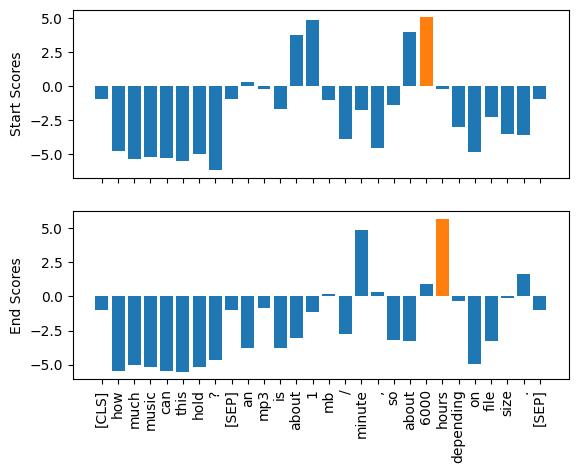

In [30]:
import numpy as np
import matplotlib.pyplot as plt

s_scores = start_logits.detach().numpy().flatten()
e_scores = end_logits.detach().numpy().flatten()
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
token_ids = range(len(tokens))

fig, (ax1, ax2) = plt.subplots(
    nrows=2, # s and e_logits
    sharex=True, # Token ids
    )

colors = ["C0" if s != max(s_scores) else "C1" for s in s_scores]
ax1.bar(
    x=token_ids,
    height=s_scores,
    color=colors,
)
ax1.set_ylabel("Start Scores")

colors = ["C0" if s != max(e_scores) else "C1" for s in e_scores]
ax2.bar(
    x=token_ids,
    height=e_scores,
    color=colors,
)
ax2.set_ylabel("End Scores")
plt.xticks(token_ids, tokens, rotation="vertical")
plt.show();


In [31]:
question

'How much music can this hold?'

Looking at the visualization, the highest logits for start and end span tokens are 6000, 1 and hours and minute respectivley.
With this respect to the question, the answer should be a number following by the unit of the number. The results look good.

Let's perform an argmax over the tokens to get the start and end token ids.

In [32]:
import torch
start_span, end_span = torch.argmax(start_logits), torch.argmax(end_logits) + 1
print(tokens[start_span:end_span])
print(tokenizer.decode(inputs["input_ids"][0][start_span:end_span]))

['6000', 'hours']
6000 hours


In [33]:
start_span, end_span

(tensor(20), tensor(22))

We have transformers pipeline which can do all this input to ids, forward pass, logits, decode logits, get answer in a single line of code.

In [35]:
from transformers import pipeline
pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)
pipe(question=question, context=context, topk=3)

/Users/jayaprakashsivagami/miniconda3/envs/nlp/lib/python3.9/site-packages/transformers/pipelines/question_answering.py:188: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


[{'score': 0.26516270637512207,
  'start': 38,
  'end': 48,
  'answer': '6000 hours'},
 {'score': 0.22082945704460144,
  'start': 16,
  'end': 48,
  'answer': '1 MB/minute, so about 6000 hours'},
 {'score': 0.10253455489873886,
  'start': 16,
  'end': 27,
  'answer': '1 MB/minute'}]

In addition to answer we get,
* `score` --> softmax over the logits, to compare multiple answers for a single context
* topk gives three top answers, multiple answers for a single question
* When the question is unanswerable, model will assign a high start and end score to the [CLS] with pipeline output an empty string

In [42]:
pipe(question="Why is there no data?", context=context, topk=3, handle_impossible_answer=True)

/Users/jayaprakashsivagami/miniconda3/envs/nlp/lib/python3.9/site-packages/transformers/pipelines/question_answering.py:188: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


[{'score': 0.9068412780761719, 'start': 0, 'end': 0, 'answer': ''},
 {'score': 0.000262648391071707,
  'start': 16,
  'end': 71,
  'answer': '1 MB/minute, so about 6000 hours depending on file size'},
 {'score': 0.00020361336646601558,
  'start': 10,
  'end': 71,
  'answer': 'about 1 MB/minute, so about 6000 hours depending on file size'}]

In [38]:
context

'An MP3 is about 1 MB/minute, so about 6000 hours depending on file size.'

> **Note:** In our simple example we took the argmax to get start and end tokens. But this heuristic approach can product out-of-scope results by selecting the tokens belonging to question instead. In pracitce start and end tokens computed by pipeline has many considereations like answer being in scope, start indices to predced the end indices and so on.